In [17]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchviz import make_dot
from sklearn.model_selection import train_test_split
import time
import torchsummary
import pandas as pd

In [18]:
def create_dictionary(text):
    """Create a dictionary from the text data.
        Args:
            text: List of strings, the text data.
        Returns:
            char_to_int: dict, a dictionary mapping characters to integers.
            int_to_char: dict, a dictionary mapping integers to characters.
    """
    chars = sorted(list(set(text)))
    char_to_int = {c: i for i, c in enumerate(chars)}
    int_to_char = {i: c for i, c in enumerate(chars)}
    return chars, char_to_int, int_to_char

def create_dataset(max_length, text, char_to_int):
    """Create a dataset from the text data.
        Args:
            max_length: int, the length of the input sequence.
            text: List of strings, the text data.
            char_to_int: dict, a dictionary mapping characters to integers.
        Returns:
            X: np.array, the input sequences.
            y: np.array, the target characters.
    """
    X = []
    y = []
    for i in range(len(text) - max_length):

        sequence = text[i:i + max_length]
        label = text[i + max_length]
        X.append([char_to_int[char] for char in sequence])
        y.append(char_to_int[label])

    X = np.array(X)
    y = np.array(y)

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train = torch.tensor(X_train, dtype=torch.long)
    y_train = torch.tensor(y_train, dtype=torch.long)
    X_val = torch.tensor(X_val, dtype=torch.long)
    y_val = torch.tensor(y_val, dtype=torch.long)

    return X_train, y_train, X_val, y_val



In [19]:


class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.5, model_type='lstm'):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size

        
        self.embedding = nn.Embedding(input_size, hidden_size)
        if model_type == 'lstm':
            self.rnn = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        elif model_type == 'gru':
            self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)
        elif model_type == 'rnn':
            self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
            
        self.fc = nn.Linear(hidden_size, output_size)
        if dropout is not False:
            self.dropout = nn.Dropout(dropout)


    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        output = self.fc(output[:, -1, :])  # Get the output of the last RNN cell
        if hasattr(self, 'dropout'):
            output = self.dropout(output)

        return output


    

In [20]:
def train(model, X_train, y_train, X_val, y_val, epochs, batch_size, learning_rate, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    val_accuracys = []
    for epoch in range(epochs):
        model.train()
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        model.eval()
        with torch.no_grad():
            X_val = X_val.to(device)
            y_val = y_val.to(device)
            val_output = model(X_val)
            val_loss = criterion(val_output, y_val)
            _, val_preds = torch.max(val_output, 1)
            val_accuracy = (val_preds == y_val).float().mean()
            val_losses.append(val_loss.item())
            val_accuracys.append(val_accuracy.item())
        if (epoch+1) % 10 == 0:
            print(f"Epoch: {epoch+1}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}, Val Accuracy: {val_accuracy.item()}")
    
    return train_losses, val_losses, val_accuracys


In [21]:
def predict_next_char(model, char_to_ix, ix_to_char, initial_str, max_length, device='cuda'):
    model.eval()
    with torch.no_grad():
        initial_input = torch.tensor([char_to_ix[c] for c in initial_str[-max_length:]], dtype=torch.long).unsqueeze(0).to(device)

        prediction = model(initial_input)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return ix_to_char[predicted_index]

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)




In [22]:
text = open('text.txt', 'r').read()
chars, char_to_int, int_to_char = create_dictionary(text)
X_train, y_train, X_val, y_val = create_dataset(10, text, char_to_int)

In [23]:
def get_results(hidden_size = 128,
                epochs = 100,
                batch_size = 64,
                learning_rate = 0.003, 
                device='cuda',
                text = text,
                chars = chars,
                char_to_int = char_to_int,
                int_to_char = int_to_char,
                max_length = 10,
                model_type = 'lstm',
                train_times = 10,
                if_dropout = 0.5):

    X_train, y_train, X_val, y_val = create_dataset(max_length, text, char_to_int)
    time_1 = time.time()
    for t in range(train_times):
        # just for getting precise time
        model = CharRNN(len(chars), hidden_size, len(chars), model_type=model_type, dropout=if_dropout)
        train_losses, val_losses, val_accuracys = train(model, X_train, y_train, X_val, y_val, epochs, batch_size, learning_rate, device)
    time_2 = time.time()
    figure, ax = plt.subplots(1, 2, figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracys, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


    target_str =  "This is a simple example to demonstrate how to predict the next char"
    predicted_results = []
    for i in range(50):
        if predicted_results:
            target_str = target_str + predicted_results[-1]
        predicted_results.append(predict_next_char(model, char_to_int, int_to_char, target_str, max_length, device))
    
    print("==========================================resutls==========================================")
    print(f'model type: {model_type}, hidden size: {hidden_size}')
    print(f'final training loss: {train_losses[-1]}, final validation loss: {val_losses[-1]}, final validation accuracy: {val_accuracys[-1]}')
    print(f'results:{target_str}')
    print(f'Average running time" {(time_2 - time_1)/train_times}')
    print(f'model complexity(number of parameters): {count_parameters(model)}')
    print("===========================================================================================")
    return {'model_type': model_type, 'max_length':max_length, 'hidden_size': hidden_size, 'final validation accuracy': val_accuracys[-1], 'Average running time': (time_2 - time_1)/train_times, 'model complexity(number of parameters)': count_parameters(model)}


## without dropout

Epoch: 10, Train Loss: 2.502687454223633, Val Loss: 2.4996252059936523, Val Accuracy: 0.33542975783348083
Epoch: 20, Train Loss: 2.085108518600464, Val Loss: 2.2745890617370605, Val Accuracy: 0.4234800636768341
Epoch: 30, Train Loss: 1.7787621021270752, Val Loss: 2.122344970703125, Val Accuracy: 0.4318658113479614
Epoch: 40, Train Loss: 1.5246332883834839, Val Loss: 2.0304882526397705, Val Accuracy: 0.4444444179534912
Epoch: 50, Train Loss: 1.2921414375305176, Val Loss: 1.995593547821045, Val Accuracy: 0.4716981053352356
Epoch: 60, Train Loss: 1.0743076801300049, Val Loss: 1.9821586608886719, Val Accuracy: 0.46960166096687317
Epoch: 70, Train Loss: 0.8687182664871216, Val Loss: 1.9976404905319214, Val Accuracy: 0.4800838530063629
Epoch: 80, Train Loss: 0.675213098526001, Val Loss: 2.0420544147491455, Val Accuracy: 0.4905660152435303
Epoch: 90, Train Loss: 0.5139678120613098, Val Loss: 2.1315176486968994, Val Accuracy: 0.509433925151825
Epoch: 100, Train Loss: 0.3610233664512634, Val Lo

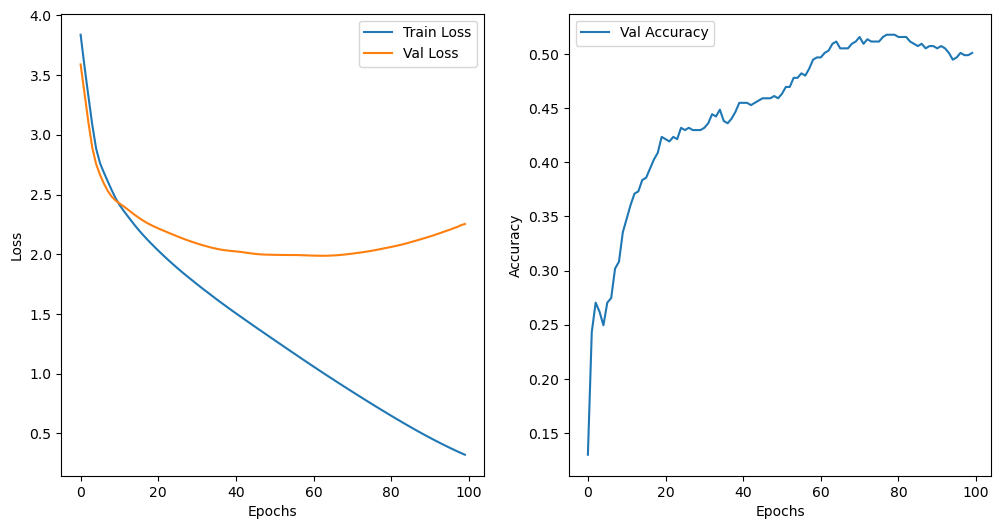

==========================================resutls==========================================
model type: rnn, hidden size: 128
final training loss: 0.32181331515312195, final validation loss: 2.2532520294189453, final validation accuracy: 0.50104820728302
results:This is a simple example to demonstrate how to predict the next character prediction involves feediction involves fee
Average running time" 0.17321035861968995
model complexity(number of parameters): 44589


In [24]:
_ = get_results(max_length=10, model_type='rnn', if_dropout=False)

In [25]:

results_list = []

## RNN

Epoch: 10, Train Loss: 3.0102384090423584, Val Loss: 2.7267050743103027, Val Accuracy: 0.3542976677417755
Epoch: 20, Train Loss: 2.8031046390533447, Val Loss: 2.4950008392333984, Val Accuracy: 0.40461215376853943
Epoch: 30, Train Loss: 2.665008544921875, Val Loss: 2.339292526245117, Val Accuracy: 0.44863730669021606
Epoch: 40, Train Loss: 2.5410518646240234, Val Loss: 2.2552011013031006, Val Accuracy: 0.45492660999298096
Epoch: 50, Train Loss: 2.418422222137451, Val Loss: 2.1805570125579834, Val Accuracy: 0.4633123576641083
Epoch: 60, Train Loss: 2.320466995239258, Val Loss: 2.1274092197418213, Val Accuracy: 0.47589096426963806
Epoch: 70, Train Loss: 2.188660144805908, Val Loss: 2.0853822231292725, Val Accuracy: 0.48846957087516785
Epoch: 80, Train Loss: 2.1559033393859863, Val Loss: 2.053774118423462, Val Accuracy: 0.50104820728302
Epoch: 90, Train Loss: 2.072380781173706, Val Loss: 2.041584014892578, Val Accuracy: 0.48218026757240295
Epoch: 100, Train Loss: 1.9878021478652954, Val Lo

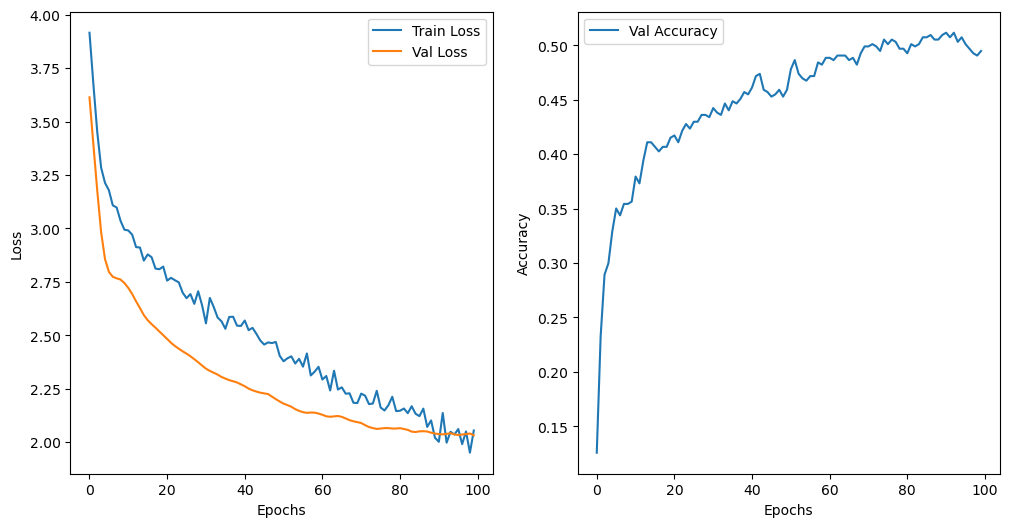

==========================================resutls==========================================
model type: rnn, hidden size: 128
final training loss: 2.0546844005584717, final validation loss: 2.032243013381958, final validation accuracy: 0.4947589039802551
results:This is a simple example to demonstrate how to predict the next character prediction involves prediction involves pre
Average running time" 0.17068107128143312
model complexity(number of parameters): 44589


In [26]:
results_list.append(get_results(max_length=10, model_type='rnn'))

Epoch: 10, Train Loss: 3.0128252506256104, Val Loss: 2.7741241455078125, Val Accuracy: 0.33052629232406616
Epoch: 20, Train Loss: 2.829511880874634, Val Loss: 2.5064289569854736, Val Accuracy: 0.40421050786972046
Epoch: 30, Train Loss: 2.674048662185669, Val Loss: 2.387068748474121, Val Accuracy: 0.44842103123664856
Epoch: 40, Train Loss: 2.5841848850250244, Val Loss: 2.2822322845458984, Val Accuracy: 0.47578945755958557
Epoch: 50, Train Loss: 2.468393325805664, Val Loss: 2.2319257259368896, Val Accuracy: 0.469473659992218
Epoch: 60, Train Loss: 2.3434460163116455, Val Loss: 2.1762895584106445, Val Accuracy: 0.469473659992218
Epoch: 70, Train Loss: 2.273576498031616, Val Loss: 2.1196391582489014, Val Accuracy: 0.4589473605155945
Epoch: 80, Train Loss: 2.141526460647583, Val Loss: 2.0743465423583984, Val Accuracy: 0.4863157570362091
Epoch: 90, Train Loss: 2.144573926925659, Val Loss: 2.064768075942993, Val Accuracy: 0.4905262887477875
Epoch: 100, Train Loss: 2.002337694168091, Val Loss:

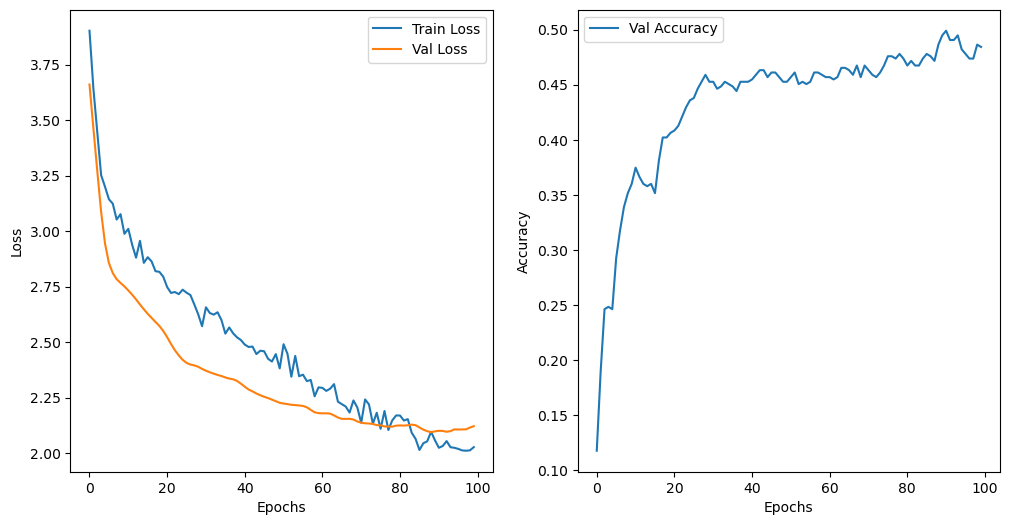

==========================================resutls==========================================
model type: rnn, hidden size: 128
final training loss: 2.0275685787200928, final validation loss: 2.1218602657318115, final validation accuracy: 0.4842104911804199
results:This is a simple example to demonstrate how to predict the next character prediction involves the model can bye next 
Average running time" 0.17174458503723145
model complexity(number of parameters): 44589


In [27]:
results_list.append(get_results(max_length=20, model_type='rnn'))

Epoch: 10, Train Loss: 2.985956907272339, Val Loss: 2.721141815185547, Val Accuracy: 0.344608873128891
Epoch: 20, Train Loss: 2.7916312217712402, Val Loss: 2.5149166584014893, Val Accuracy: 0.39534881711006165
Epoch: 30, Train Loss: 2.6217257976531982, Val Loss: 2.392896890640259, Val Accuracy: 0.41860464215278625
Epoch: 40, Train Loss: 2.5349526405334473, Val Loss: 2.30263090133667, Val Accuracy: 0.4439746141433716
Epoch: 50, Train Loss: 2.426084041595459, Val Loss: 2.2537195682525635, Val Accuracy: 0.45665961503982544
Epoch: 60, Train Loss: 2.2892260551452637, Val Loss: 2.1953518390655518, Val Accuracy: 0.47991544008255005
Epoch: 70, Train Loss: 2.2674221992492676, Val Loss: 2.138881206512451, Val Accuracy: 0.48414376378059387
Epoch: 80, Train Loss: 2.1657752990722656, Val Loss: 2.124734878540039, Val Accuracy: 0.47991544008255005
Epoch: 90, Train Loss: 2.0610246658325195, Val Loss: 2.113300323486328, Val Accuracy: 0.4862579107284546
Epoch: 100, Train Loss: 2.0054452419281006, Val Lo

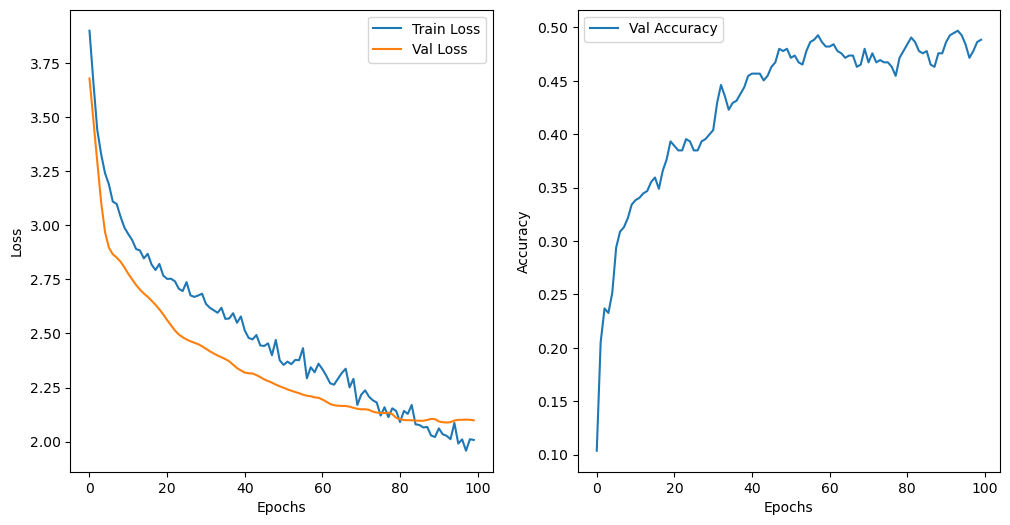

==========================================resutls==========================================
model type: rnn, hidden size: 128
final training loss: 2.0080325603485107, final validation loss: 2.098827838897705, final validation accuracy: 0.4883720874786377
results:This is a simple example to demonstrate how to predict the next character prediction involves the use of text and pre
Average running time" 0.1953436851501465
model complexity(number of parameters): 44589


In [28]:
results_list.append(get_results(max_length=30, model_type='rnn'))

## GRU

Epoch: 10, Train Loss: 3.0728652477264404, Val Loss: 2.794410467147827, Val Accuracy: 0.33752620220184326
Epoch: 20, Train Loss: 2.8663134574890137, Val Loss: 2.4941647052764893, Val Accuracy: 0.4213836193084717
Epoch: 30, Train Loss: 2.6730797290802, Val Loss: 2.3039658069610596, Val Accuracy: 0.46121591329574585
Epoch: 40, Train Loss: 2.547987461090088, Val Loss: 2.159954786300659, Val Accuracy: 0.4716981053352356
Epoch: 50, Train Loss: 2.356159210205078, Val Loss: 2.0818262100219727, Val Accuracy: 0.5052410960197449
Epoch: 60, Train Loss: 2.234661340713501, Val Loss: 2.0069777965545654, Val Accuracy: 0.5115303993225098
Epoch: 70, Train Loss: 2.1483566761016846, Val Loss: 1.9574851989746094, Val Accuracy: 0.5387840270996094
Epoch: 80, Train Loss: 2.009592056274414, Val Loss: 1.9389821290969849, Val Accuracy: 0.5366876125335693
Epoch: 90, Train Loss: 1.973496437072754, Val Loss: 1.937668800354004, Val Accuracy: 0.5450733304023743
Epoch: 100, Train Loss: 1.8750956058502197, Val Loss: 1

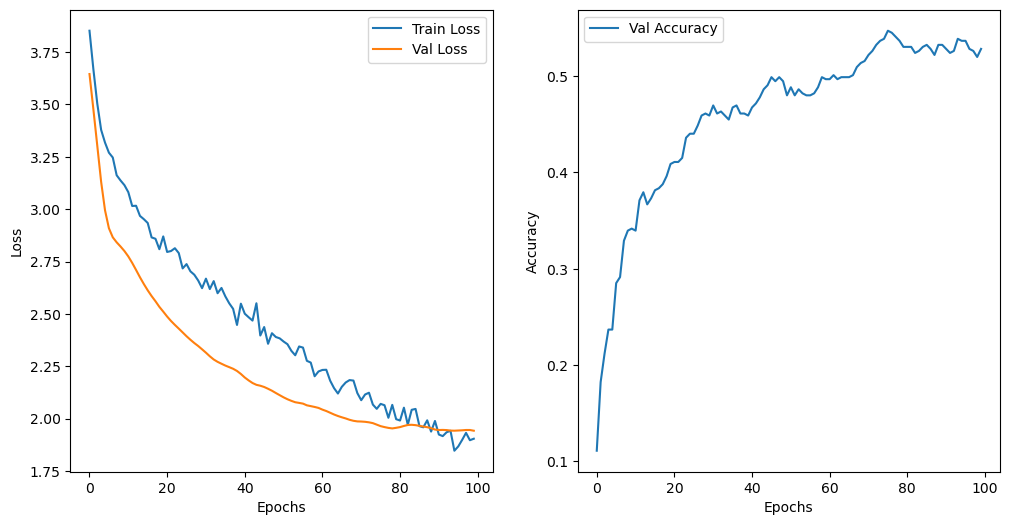

==========================================resutls==========================================
model type: gru, hidden size: 128
final training loss: 1.9042415618896484, final validation loss: 1.942407250404358, final validation accuracy: 0.5283018946647644
results:This is a simple example to demonstrate how to predict the next character prediction involves prediction involves pre
Average running time" 0.21040785312652588
model complexity(number of parameters): 110637


In [29]:
results_list.append(get_results(max_length=10, model_type='gru'))

Epoch: 10, Train Loss: 3.032881021499634, Val Loss: 2.856184959411621, Val Accuracy: 0.27157893776893616
Epoch: 20, Train Loss: 2.832120180130005, Val Loss: 2.5406651496887207, Val Accuracy: 0.40421050786972046
Epoch: 30, Train Loss: 2.6449007987976074, Val Loss: 2.3614346981048584, Val Accuracy: 0.45052629709243774
Epoch: 40, Train Loss: 2.5275425910949707, Val Loss: 2.220916986465454, Val Accuracy: 0.5094736814498901
Epoch: 50, Train Loss: 2.372943639755249, Val Loss: 2.1219582557678223, Val Accuracy: 0.5178946852684021
Epoch: 60, Train Loss: 2.2388246059417725, Val Loss: 2.0417628288269043, Val Accuracy: 0.5326315760612488
Epoch: 70, Train Loss: 2.161158561706543, Val Loss: 1.9959430694580078, Val Accuracy: 0.5494736433029175
Epoch: 80, Train Loss: 2.0044775009155273, Val Loss: 1.9632383584976196, Val Accuracy: 0.5410525798797607
Epoch: 90, Train Loss: 1.9620444774627686, Val Loss: 1.963527798652649, Val Accuracy: 0.5410525798797607
Epoch: 100, Train Loss: 1.883582592010498, Val Los

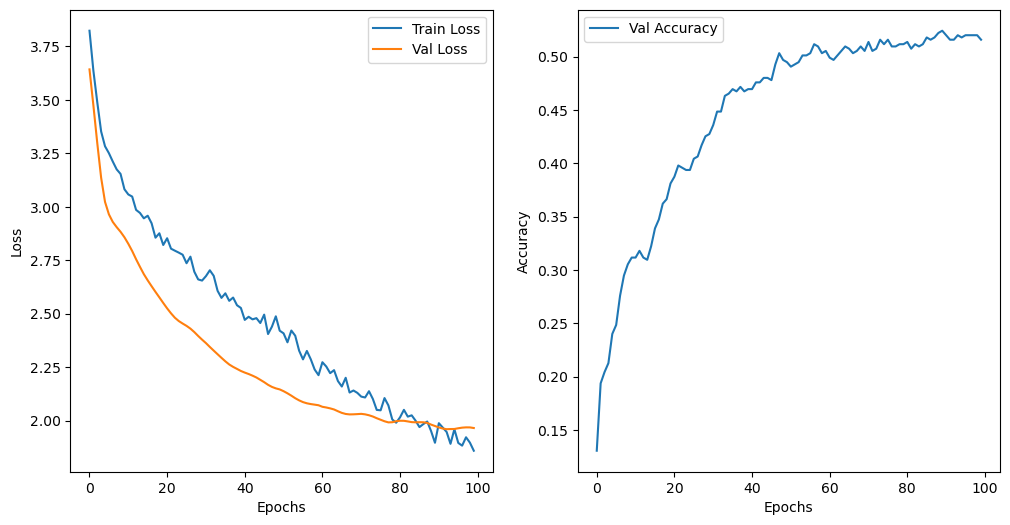

==========================================resutls==========================================
model type: gru, hidden size: 128
final training loss: 1.8593385219573975, final validation loss: 1.9655038118362427, final validation accuracy: 0.5157894492149353
results:This is a simple example to demonstrate how to predict the next character prediction involves the model can based on 
Average running time" 0.2913475751876831
model complexity(number of parameters): 110637


In [30]:
results_list.append(get_results(max_length=20, model_type='gru'))

Epoch: 10, Train Loss: 3.116203784942627, Val Loss: 2.852668523788452, Val Accuracy: 0.302325576543808
Epoch: 20, Train Loss: 2.863194465637207, Val Loss: 2.579810380935669, Val Accuracy: 0.3636363446712494
Epoch: 30, Train Loss: 2.657155752182007, Val Loss: 2.409014940261841, Val Accuracy: 0.41437631845474243
Epoch: 40, Train Loss: 2.5433545112609863, Val Loss: 2.3205819129943848, Val Accuracy: 0.44186046719551086
Epoch: 50, Train Loss: 2.416414499282837, Val Loss: 2.225186347961426, Val Accuracy: 0.4693446159362793
Epoch: 60, Train Loss: 2.217275619506836, Val Loss: 2.1622042655944824, Val Accuracy: 0.45877379179000854
Epoch: 70, Train Loss: 2.1697869300842285, Val Loss: 2.112447500228882, Val Accuracy: 0.47991544008255005
Epoch: 80, Train Loss: 2.076533317565918, Val Loss: 2.09460711479187, Val Accuracy: 0.4904862642288208
Epoch: 90, Train Loss: 1.9416117668151855, Val Loss: 2.0725462436676025, Val Accuracy: 0.4904862642288208
Epoch: 100, Train Loss: 1.9260321855545044, Val Loss: 2.

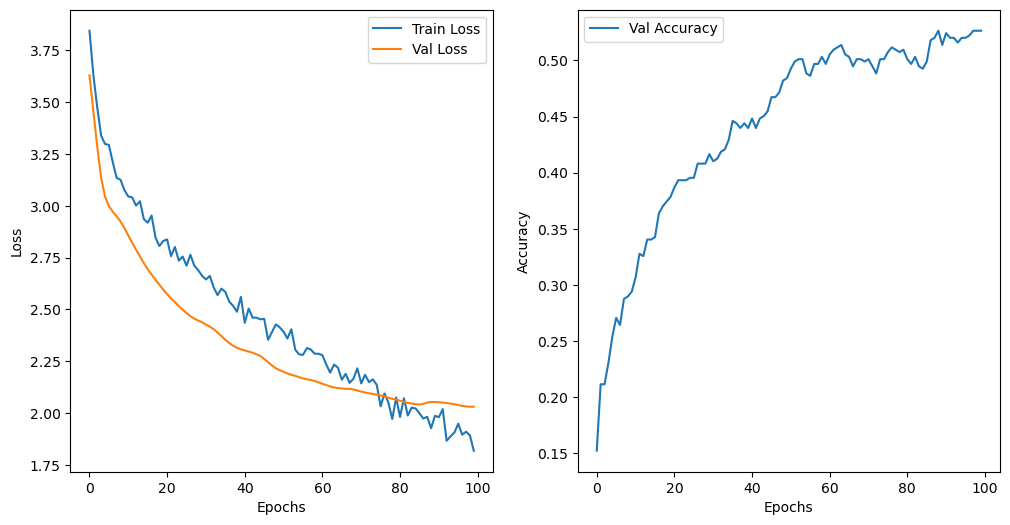

==========================================resutls==========================================
model type: gru, hidden size: 128
final training loss: 1.8192137479782104, final validation loss: 2.0316202640533447, final validation accuracy: 0.5264270305633545
results:This is a simple example to demonstrate how to predict the next character prediction involves the use of and enable m
Average running time" 0.3890045404434204
model complexity(number of parameters): 110637


In [31]:
results_list.append(get_results(max_length=30, model_type='gru'))

## lstm

Epoch: 10, Train Loss: 3.128453016281128, Val Loss: 2.9062535762786865, Val Accuracy: 0.2893081605434418
Epoch: 20, Train Loss: 2.9202401638031006, Val Loss: 2.5614192485809326, Val Accuracy: 0.402515709400177
Epoch: 30, Train Loss: 2.71626877784729, Val Loss: 2.389760971069336, Val Accuracy: 0.44654086232185364
Epoch: 40, Train Loss: 2.6231226921081543, Val Loss: 2.2309980392456055, Val Accuracy: 0.44863730669021606
Epoch: 50, Train Loss: 2.4418866634368896, Val Loss: 2.1591899394989014, Val Accuracy: 0.47589096426963806
Epoch: 60, Train Loss: 2.3342783451080322, Val Loss: 2.085007429122925, Val Accuracy: 0.4863731563091278
Epoch: 70, Train Loss: 2.207031011581421, Val Loss: 2.032472610473633, Val Accuracy: 0.49685531854629517
Epoch: 80, Train Loss: 2.14619517326355, Val Loss: 2.0098578929901123, Val Accuracy: 0.4926624596118927
Epoch: 90, Train Loss: 2.017927646636963, Val Loss: 1.9969431161880493, Val Accuracy: 0.4926624596118927
Epoch: 100, Train Loss: 1.9184399843215942, Val Loss:

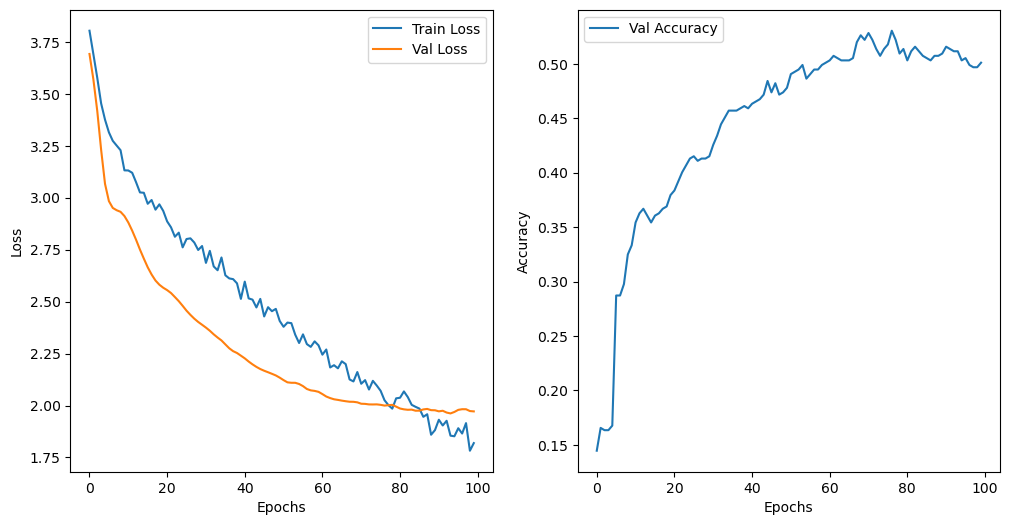

==========================================resutls==========================================
model type: lstm, hidden size: 128
final training loss: 1.8191114664077759, final validation loss: 1.9716931581497192, final validation accuracy: 0.50104820728302
results:This is a simple example to demonstrate how to predict the next character prediction involves prediction involves pre
Average running time" 0.2580381155014038
model complexity(number of parameters): 143661


In [32]:
results_list.append(get_results(max_length=10, model_type='lstm'))

Epoch: 10, Train Loss: 3.173841953277588, Val Loss: 2.979186773300171, Val Accuracy: 0.2757894694805145
Epoch: 20, Train Loss: 2.915393590927124, Val Loss: 2.604139566421509, Val Accuracy: 0.355789452791214
Epoch: 30, Train Loss: 2.7077536582946777, Val Loss: 2.4416656494140625, Val Accuracy: 0.40631577372550964
Epoch: 40, Train Loss: 2.5224316120147705, Val Loss: 2.2957963943481445, Val Accuracy: 0.442105233669281
Epoch: 50, Train Loss: 2.4551913738250732, Val Loss: 2.2035133838653564, Val Accuracy: 0.4568420946598053
Epoch: 60, Train Loss: 2.3077046871185303, Val Loss: 2.1058239936828613, Val Accuracy: 0.4905262887477875
Epoch: 70, Train Loss: 2.1678686141967773, Val Loss: 2.067842483520508, Val Accuracy: 0.4715789258480072
Epoch: 80, Train Loss: 2.0892107486724854, Val Loss: 2.0219621658325195, Val Accuracy: 0.5157894492149353
Epoch: 90, Train Loss: 1.9947595596313477, Val Loss: 2.0081968307495117, Val Accuracy: 0.524210512638092
Epoch: 100, Train Loss: 1.8083406686782837, Val Loss:

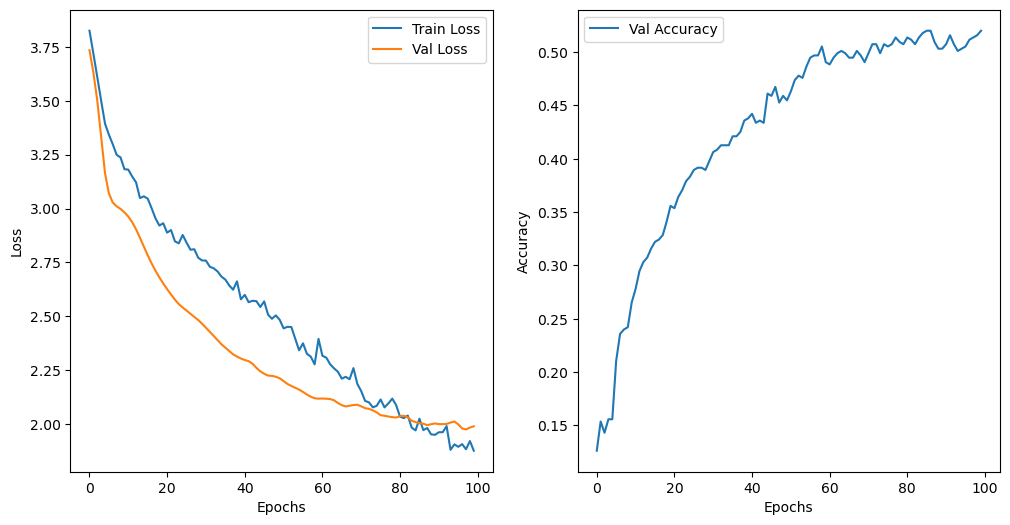

==========================================resutls==========================================
model type: lstm, hidden size: 128
final training loss: 1.8761295080184937, final validation loss: 1.9895312786102295, final validation accuracy: 0.5199999809265137
results:This is a simple example to demonstrate how to predict the next character in a given pell caraining proces, the model
Average running time" 0.3612357139587402
model complexity(number of parameters): 143661


In [33]:
results_list.append(get_results(max_length=20, model_type='lstm'))

Epoch: 10, Train Loss: 3.129790782928467, Val Loss: 2.9898834228515625, Val Accuracy: 0.2854122519493103
Epoch: 20, Train Loss: 2.9450876712799072, Val Loss: 2.635256052017212, Val Accuracy: 0.35306552052497864
Epoch: 30, Train Loss: 2.7568342685699463, Val Loss: 2.47866153717041, Val Accuracy: 0.4016913175582886
Epoch: 40, Train Loss: 2.63334059715271, Val Loss: 2.3407177925109863, Val Accuracy: 0.4249471426010132
Epoch: 50, Train Loss: 2.4909279346466064, Val Loss: 2.2512106895446777, Val Accuracy: 0.4503171145915985
Epoch: 60, Train Loss: 2.2855677604675293, Val Loss: 2.180718421936035, Val Accuracy: 0.46088793873786926
Epoch: 70, Train Loss: 2.174807548522949, Val Loss: 2.1214346885681152, Val Accuracy: 0.45877379179000854
Epoch: 80, Train Loss: 2.055880546569824, Val Loss: 2.091665744781494, Val Accuracy: 0.4672304391860962
Epoch: 90, Train Loss: 1.9760228395462036, Val Loss: 2.049983263015747, Val Accuracy: 0.4693446159362793
Epoch: 100, Train Loss: 1.8668380975723267, Val Loss: 

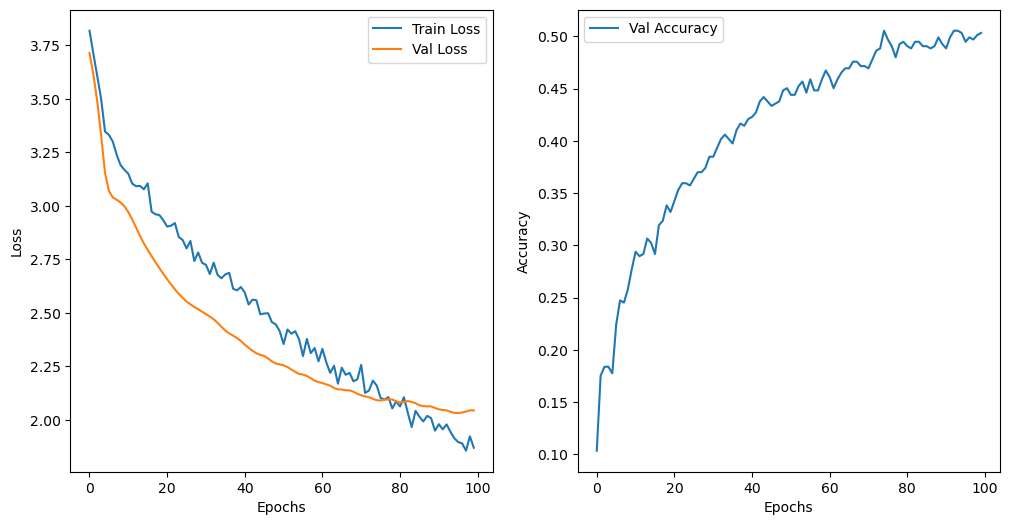

==========================================resutls==========================================
model type: lstm, hidden size: 128
final training loss: 1.8702973127365112, final validation loss: 2.044358253479004, final validation accuracy: 0.5031712651252747
results:This is a simple example to demonstrate how to predict the next character prediction involves the use of text data, a
Average running time" 0.46549434661865235
model complexity(number of parameters): 143661


In [34]:
results_list.append(get_results(max_length=30, model_type='lstm'))

In [35]:
results = pd.DataFrame.from_dict(results_list)
results

,model_type,max_length,hidden_size,final validation accuracy,Average running time,model complexity(number of parameters)
0,rnn,10,128,0.494759,0.170681,44589
1,rnn,20,128,0.484210,0.171745,44589
2,rnn,30,128,0.488372,0.195344,44589
3,gru,10,128,0.528302,0.210408,110637
4,gru,20,128,0.515789,0.291348,110637
5,gru,30,128,0.526427,0.389005,110637
6,lstm,10,128,0.501048,0.258038,143661
7,lstm,20,128,0.520000,0.361236,143661
8,lstm,30,128,0.503171,0.465494,143661
